
# Demo 8 — Variational Autoencoder (VAE) on MNIST

**Problem:** Learn a compact **probabilistic latent representation** of images and use it to **reconstruct** inputs and **generate new samples**. Dataset: **MNIST** (28×28 grayscale digits).

**Inputs:** 28×28 pixel tensors.  
**Outputs:** Reconstructed images of the same shape; plus **new images** sampled by drawing \( z \sim \mathcal{N}(0, I) \) and decoding.

**Goal:**  
1) Train a VAE (encoder → \( \mu, \log\sigma^2 \); reparam \( z = \mu + \sigma \odot \epsilon \); decoder → reconstruction).  
2) Achieve low reconstruction error while maintaining a **well-regularized** latent space via the KL term.  
3) Demonstrate **generation** by sampling random \( z \) and decoding to realistic digits.

**Loss (ELBO):** `total = recon_loss + β * KL(q(z|x) || N(0, I))`

**Success Criteria:**  
- Quantitative: reconstruction loss ↓; stable KL term.  
- Qualitative: input vs reconstruction looks faithful; latent interpolation is smooth; random samples look like digits.


## 1. Import libraries and set random seeds

In [1]:

# Check versions and import libraries
import sys, os, time, math, random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("Python:", sys.version.split()[0])
print("TensorFlow:", tf.__version__)

# Reproducibility
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)



Python: 3.10.11
TensorFlow: 2.15.0
Python: 3.10.11
TensorFlow: 2.15.0


## 2. Configuration (latent dimension, batch size, etc.)

In [2]:

# Configuration (edit as needed)
LATENT_DIM = 2        # 2D for easy visualization
BATCH_SIZE = 256
EPOCHS = 10           # keep small for fast demo; increase for better quality
BETA = 1.0            # weight for KL term (β-VAE if you change this)
LEARNING_RATE = 1e-3

SAVE_DIR = "vae_demo8_artifacts"
os.makedirs(SAVE_DIR, exist_ok=True)


## 3. Load and preprocess MNIST data

In [3]:

# Load MNIST and normalize to [0,1]
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

# Add channel dimension
x_train = np.expand_dims(x_train, -1)  # (60000, 28, 28, 1)
x_test  = np.expand_dims(x_test,  -1)  # (10000, 28, 28, 1)

print("Train:", x_train.shape, " Test:", x_test.shape)


11490434/11490434 [==============================] - 4s 0us/step
Train: (60000, 28, 28, 1)  Test: (10000, 28, 28, 1)
Train: (60000, 28, 28, 1)  Test: (10000, 28, 28, 1)


## 4. Define the reparameterization trick layer

In [4]:

# Reparameterization trick: z = mu + sigma * eps
class Sampling(layers.Layer):
    def call(self, inputs):
        mu, log_var = inputs
        eps = tf.random.normal(shape=tf.shape(mu))
        return mu + tf.exp(0.5 * log_var) * eps


## 5. Build encoder and decoder models

In [5]:

# Encoder
encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
z_mean = layers.Dense(LATENT_DIM, name="z_mean")(x)
z_log_var = layers.Dense(LATENT_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

# Decoder
latent_inputs = keras.Input(shape=(LATENT_DIM,))
x = layers.Dense(7*7*64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()



Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 14, 14, 32)           320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 7, 7, 64)             18496     ['conv2d[0][0]']              
                                                                                                  
 flatten (Flatten)           (None, 3136)                 0         ['conv2d_1[0][0]']            
                                                                                           

## 6. Define the VAE model and training logic

In [6]:

class VAE(keras.Model):
    def __init__(self, encoder, decoder, beta=1.0, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.recon_loss_tracker = keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.recon_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            # Reconstruction loss: Binary Crossentropy per pixel
            bce = tf.keras.losses.binary_crossentropy(data, reconstruction)
            recon_loss = tf.reduce_mean(tf.reduce_sum(bce, axis=(1,2)))
            # KL divergence
            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))
            total_loss = recon_loss + self.beta * kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {"loss": self.total_loss_tracker.result(),
                "recon_loss": self.recon_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result()}

    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        bce = tf.keras.losses.binary_crossentropy(data, reconstruction)
        recon_loss = tf.reduce_mean(tf.reduce_sum(bce, axis=(1,2)))
        kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))
        total_loss = recon_loss + self.beta * kl_loss
        return {"loss": total_loss, "recon_loss": recon_loss, "kl_loss": kl_loss}


## 7. Train the VAE and save weights

In [7]:

vae = VAE(encoder, decoder, beta=BETA)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

history = vae.fit(
    x_train, x_train,
    validation_data=(x_test, x_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Save model weights
vae.save_weights(os.path.join(SAVE_DIR, "vae_weights.h5"))
print("Saved weights to:", os.path.join(SAVE_DIR, "vae_weights.h5"))


Epoch 1/10
235/235 [==============================] - 29s 109ms/step - loss: 293.9204 - recon_loss: 222.3078 - kl_loss: 3.5151 - val_loss: 190.7947 - val_recon_loss: 186.6022 - val_kl_loss: 4.1924
Epoch 2/10
235/235 [==============================] - 29s 109ms/step - loss: 293.9204 - recon_loss: 222.3078 - kl_loss: 3.5151 - val_loss: 190.7947 - val_recon_loss: 186.6022 - val_kl_loss: 4.1924
Epoch 2/10
235/235 [==============================] - 25s 107ms/step - loss: 177.1067 - recon_loss: 169.0886 - kl_loss: 4.4759 - val_loss: 166.5144 - val_recon_loss: 161.7636 - val_kl_loss: 4.7507
Epoch 3/10
235/235 [==============================] - 25s 107ms/step - loss: 177.1067 - recon_loss: 169.0886 - kl_loss: 4.4759 - val_loss: 166.5144 - val_recon_loss: 161.7636 - val_kl_loss: 4.7507
Epoch 3/10
235/235 [==============================] - 25s 104ms/step - loss: 164.9123 - recon_loss: 158.1748 - kl_loss: 5.0366 - val_loss: 161.7049 - val_recon_loss: 156.4045 - val_kl_loss: 5.3005
Epoch 4/10
235/

## 8. Plot training and validation losses

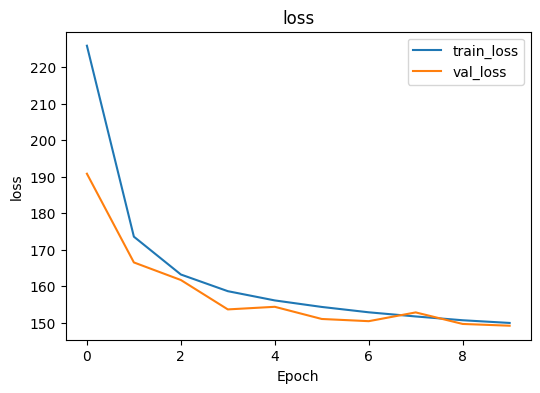

Saved: vae_demo8_artifacts\loss.png


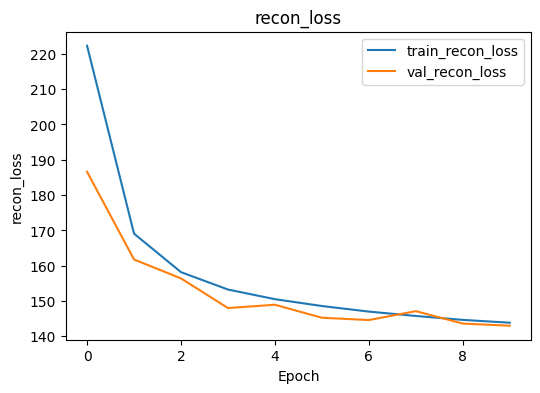

Saved: vae_demo8_artifacts\recon_loss.png


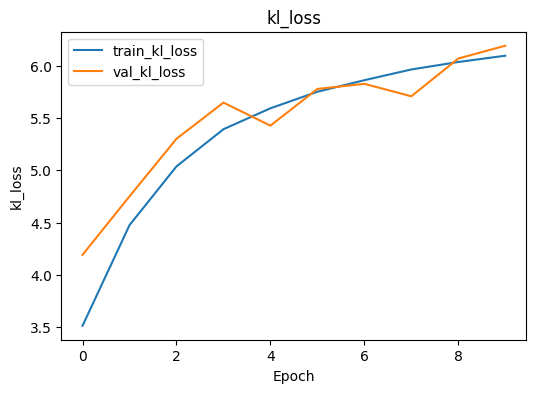

Saved: vae_demo8_artifacts\kl_loss.png


In [8]:

# Plot training/validation losses (one chart per metric)
def plot_metric(metric_name):
    plt.figure(figsize=(6,4))
    plt.plot(history.history.get(metric_name, []), label=f"train_{metric_name}")
    val_key = f"val_{metric_name}"
    if val_key in history.history:
        plt.plot(history.history[val_key], label=f"val_{metric_name}")
    plt.title(metric_name)
    plt.xlabel("Epoch")
    plt.ylabel(metric_name)
    plt.legend()
    fname = os.path.join(SAVE_DIR, f"{metric_name}.png")
    plt.savefig(fname, bbox_inches="tight", dpi=120)
    plt.show()
    print("Saved:", fname)

for m in ["loss", "recon_loss", "kl_loss"]:
    plot_metric(m)


## 9. Visualize original vs reconstructed images

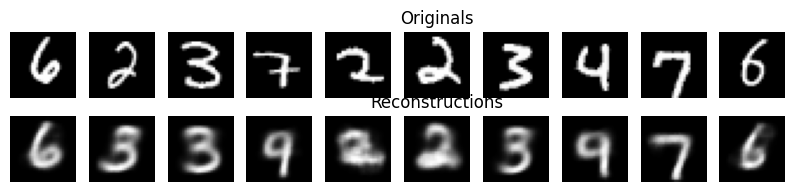

Saved: vae_demo8_artifacts\reconstructions.png


In [9]:

# Visualize original vs reconstruction
def show_reconstructions(n=10):
    idx = np.random.choice(len(x_test), n, replace=False)
    originals = x_test[idx]
    z_mean, z_log_var, z = encoder.predict(originals, verbose=0)
    rec = decoder.predict(z, verbose=0)
    # Display
    plt.figure(figsize=(n, 2))
    # Originals
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(originals[i].squeeze(), cmap="gray")
        plt.axis("off")
        if i == n//2:
            ax.set_title("Originals")
    # Reconstructions
    for i in range(n):
        ax = plt.subplot(2, n, n + i + 1)
        plt.imshow(rec[i].squeeze(), cmap="gray")
        plt.axis("off")
        if i == n//2:
            ax.set_title("Reconstructions")
    fname = os.path.join(SAVE_DIR, "reconstructions.png")
    plt.savefig(fname, bbox_inches="tight", dpi=120)
    plt.show()
    print("Saved:", fname)

show_reconstructions(10)


## 10. Generate new samples from random latent vectors

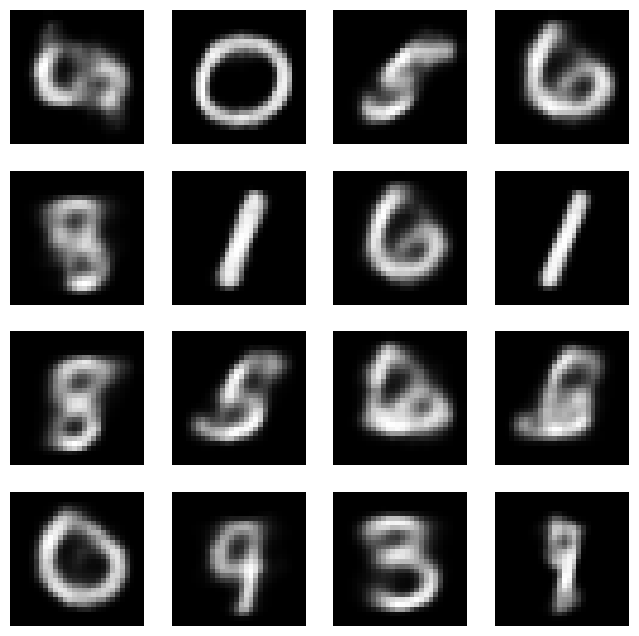

Saved: vae_demo8_artifacts\random_samples.png


In [10]:

# Sample random z ~ N(0, I) and decode
def sample_random(n=16):
    z = np.random.normal(size=(n, LATENT_DIM)).astype("float32")
    imgs = decoder.predict(z, verbose=0)
    side = int(math.sqrt(n))
    plt.figure(figsize=(side*2, side*2))
    for i in range(n):
        ax = plt.subplot(side, side, i + 1)
        plt.imshow(imgs[i].squeeze(), cmap="gray")
        plt.axis("off")
    fname = os.path.join(SAVE_DIR, "random_samples.png")
    plt.savefig(fname, bbox_inches="tight", dpi=120)
    plt.show()
    print("Saved:", fname)

sample_random(16)


## 11. Visualize the 2D latent space (if applicable)

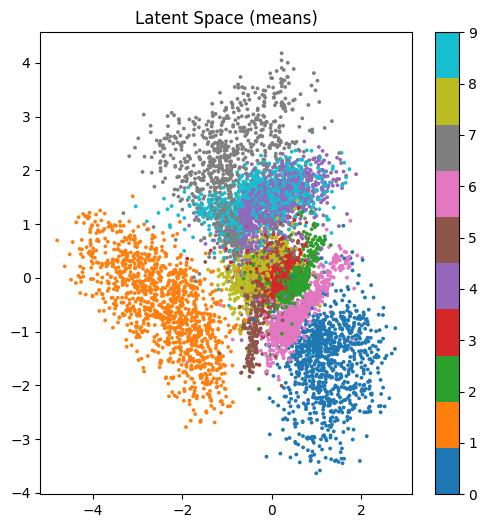

Saved: vae_demo8_artifacts\latent_space.png


In [11]:

# Plot 2D latent means colored by true digit (works when LATENT_DIM == 2)
if LATENT_DIM == 2:
    z_mu, z_lv, z = encoder.predict(x_test, verbose=0)
    plt.figure(figsize=(6,6))
    plt.scatter(z_mu[:,0], z_mu[:,1], s=3, c=y_test, cmap="tab10")
    plt.colorbar()
    plt.title("Latent Space (means)")
    fname = os.path.join(SAVE_DIR, "latent_space.png")
    plt.savefig(fname, bbox_inches="tight", dpi=120)
    plt.show()
    print("Saved:", fname)
else:
    print("LATENT_DIM != 2; skipping 2D latent plot.")


## 12. Interpolate between two test images in latent space

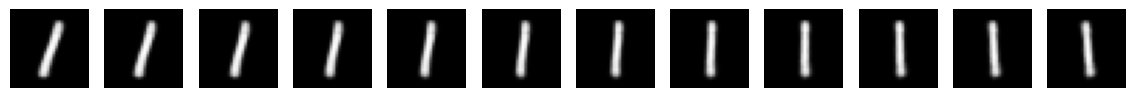

Saved: vae_demo8_artifacts\interpolation.png


In [12]:

# Interpolate between two test images in latent space
def interpolate(n_steps=10):
    i, j = np.random.choice(len(x_test), 2, replace=False)
    a, b = x_test[i:i+1], x_test[j:j+1]
    mu_a, _, z_a = encoder.predict(a, verbose=0)
    mu_b, _, z_b = encoder.predict(b, verbose=0)
    alphas = np.linspace(0, 1, n_steps)
    z_interp = np.array([(1-a_) * mu_a + a_ * mu_b for a_ in alphas]).squeeze(axis=1)
    imgs = decoder.predict(z_interp, verbose=0)
    plt.figure(figsize=(n_steps*1.2, 1.5))
    for k in range(n_steps):
        ax = plt.subplot(1, n_steps, k + 1)
        plt.imshow(imgs[k].squeeze(), cmap="gray")
        plt.axis("off")
    fname = os.path.join(SAVE_DIR, "interpolation.png")
    plt.savefig(fname, bbox_inches="tight", dpi=120)
    plt.show()
    print("Saved:", fname)

interpolate(12)


## 13. Utility functions for inference

In [13]:

# Utility functions for inference
def encode_images(x):
    z_mean, z_log_var, z = encoder.predict(x, verbose=0)
    return z_mean, z_log_var, z

def decode_latents(z):
    return decoder.predict(z, verbose=0)

print("Utilities ready: encode_images, decode_latents")


Utilities ready: encode_images, decode_latents
